Buoy data processing

In [56]:
import os
import pandas as pd
import proplot as pplt
import numpy as np
from importlib import reload
drifter = reload(drifter)
%run ../scripts/prepare_buoy_data.py

P-buoys with at least one observation 64
P-buoys exceeding minimum coverage 57
Observations in bounding box 22 less than min size 50


In [45]:
##### Load buoy data #####
buoy_dataloc = '../data/interpolated_tracks/'
buoy_data = {}
metadataloc = '../data/adc_dn_tracks/'
metadata = pd.read_csv(metadataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
metadata.set_index('Sensor ID', inplace=True)

files = os.listdir(buoy_dataloc)
files = [f for f in files if f[0] not in ['.', 'm']]
buoy_data = {f.split('_')[-1].replace('.csv', ''): pd.read_csv(buoy_dataloc + f,
            index_col=0, parse_dates=True) for f in files}

In [46]:
left = ['2019P128', '2019P184', '2019P182', '2019P127']
right = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
distant = ['2019P156', '2019P157']
ahead = ['2019P22']
l_sites = ['2019T67', '2019T65', '2019S94']
co = ['2019T66']
site_specs = {'2019T67': ('tab:blue', 's', 8, 1),
               '2019T65': ('powder blue', 's', 8, 2),
               '2019S94': ('tab:green', 's', 8, 3),
               '2019T66': ('tab:red', '*', 15, 0)}
date = '2020-02-01 00:00'
all_buoys = [b for b in buoy_data if date in buoy_data[b].index]
dn_buoys = [b for b in all_buoys if b not in left + right + distant]


check_ts = slice('2020-01-25 0:00', '2020-02-05 0:00')

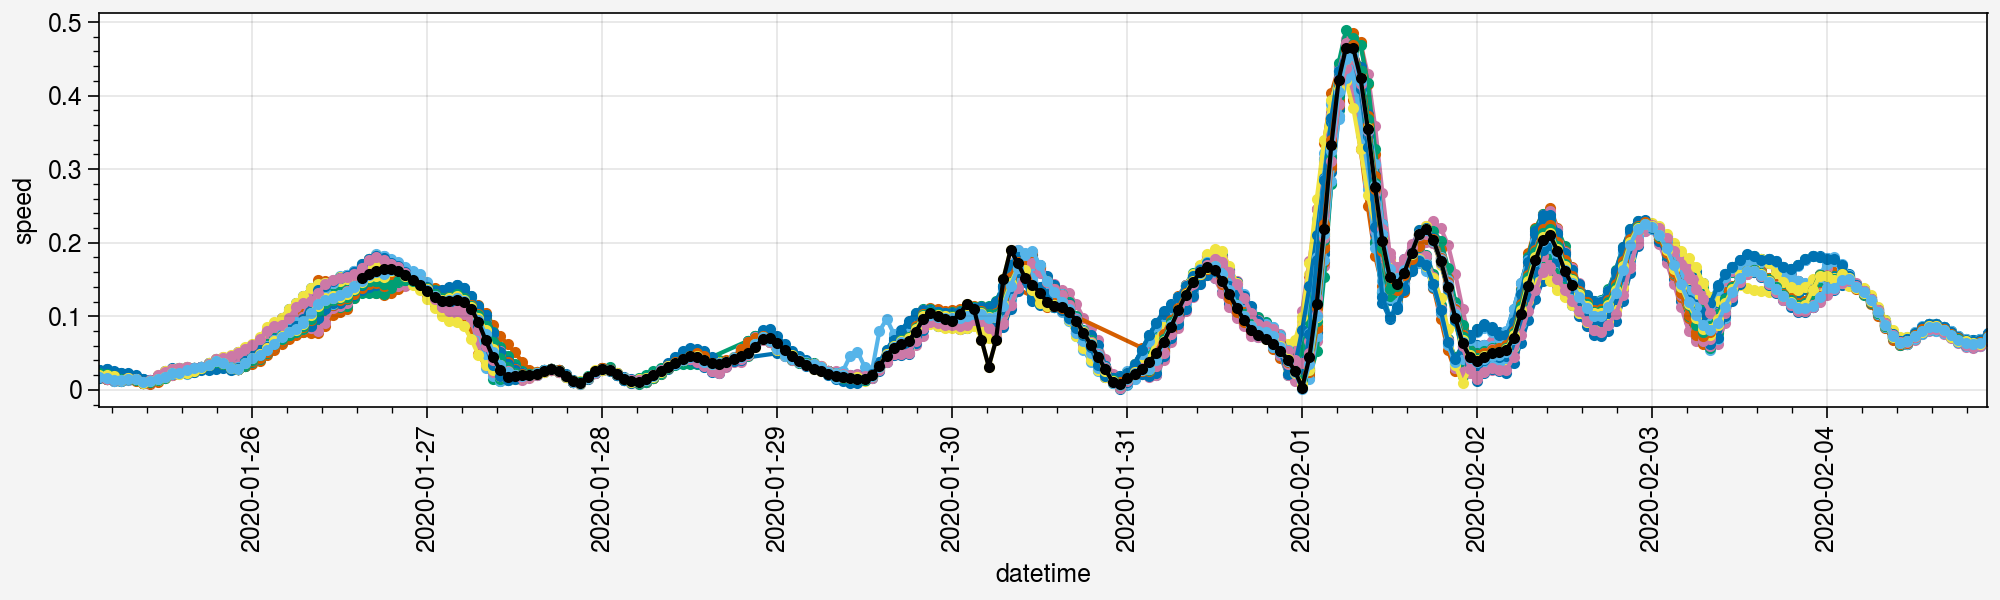

In [48]:
mini_ts = slice('2020-01-30 18:00', '2020-01-30 20:00')
fig, ax = pplt.subplots(width=10, height=3)
for buoy in dn_buoys:
    if buoy_data[buoy].loc[mini_ts, 'u'].max() > 0.015:
        print(buoy)
    elif True: #buoy not in error_buoys:
         ax.plot(buoy_data[buoy].loc[check_ts].speed, marker='.', zorder=1)
    if buoy=='2019P146':
        ax.plot(buoy_data[buoy].loc[check_ts].speed, marker='.', zorder=20, color='k')

In [11]:
error_buoys = ['2019P137', '2019P138', '2019P139',
               '2019P148', '2019P146', '2019P183',
               '2019P203', '2019O1']

In [7]:
buoy_orig = {}
for f in os.listdir('../data/adc_dn_tracks/'):
    buoy = f.split('_')[-1].replace('.csv', '')
    if buoy in buoy_data:
        buoy_orig[buoy] = pd.read_csv('../data/adc_dn_tracks/' + f, index_col='datetime', parse_dates=True).loc[check_ts]


In [8]:
import sys
sys.path.append('../scripts/')
import drifter

In [12]:
buoy = error_buoys[0]
for buoy in buoy_orig:
    # buoy_orig[buoy] = drifter.regrid_buoy_track(buoy_orig[buoy])
    buoy_orig[buoy] = drifter.compute_velocity(buoy_orig[buoy], rotate_uv=True, method='c')
    buoy_orig[buoy]['speed_check'] = drifter.check_speed(buoy_orig[buoy])

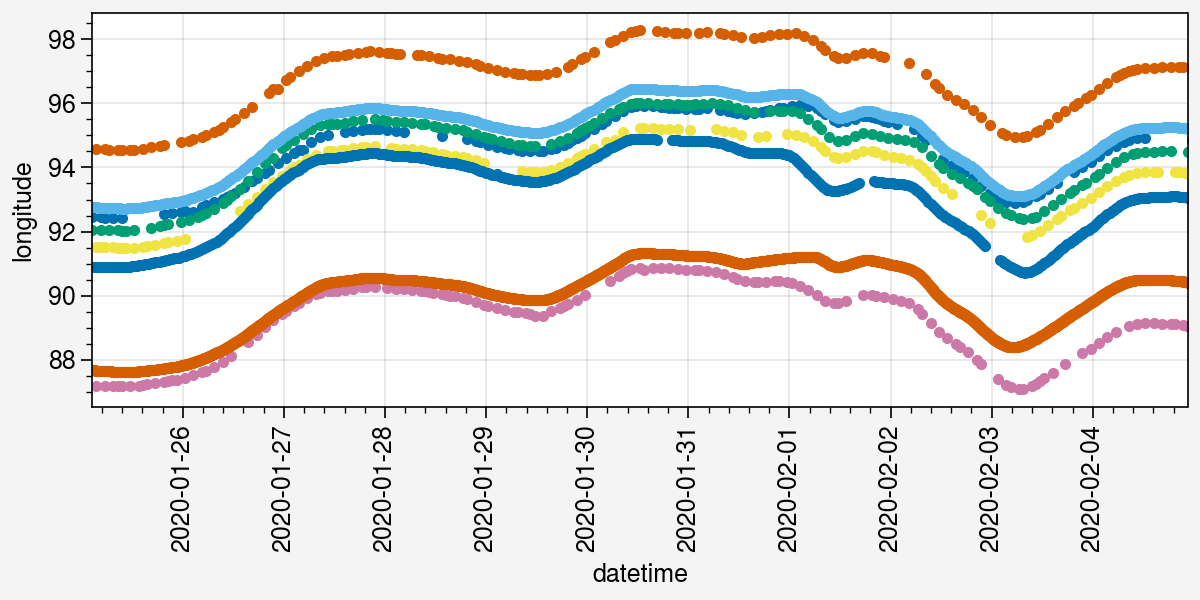

In [13]:
fig, ax = pplt.subplots(width=6, height=3)
for buoy in error_buoys:
    ax.plot(buoy_orig[buoy].loc[check_ts].longitude, marker='.', lw=0)
    ax.plot(buoy_orig[buoy].loc[check_ts].longitude.where(buoy_orig[buoy]['speed_check']), marker='.', lw=0, color='k')

In [14]:
buoy_df = buoy_orig['2019P148']
df = drifter.compute_velocity(buoy_df, date_index=True, method='fb')
def zscore(df, window='3D', n_min=10):
        uscore = (df['u'] - df['u'].rolling(window, center=True, min_periods=n_min).mean()) / \
                 df['u'].rolling(window, center=True, min_periods=n_min).std()
        vscore = (df['v'] - df['v'].rolling(window, center=True, min_periods=n_min).mean()) / \
                 df['v'].rolling(window, center=True, min_periods=n_min).std()

        zu_anom = uscore - uscore.rolling(window, center=True, min_periods=n_min).median()
        zv_anom = vscore - vscore.rolling(window, center=True, min_periods=n_min).median()
        return zu_anom, zv_anom
zu_init, zv_init = zscore(df)
buoy_df2 = buoy_data['2019P148'].copy()
df2 = drifter.compute_velocity(buoy_df2, date_index=True, method='fb')
zu, zv = zscore(df2)

<a list of 1 Line2D objects>

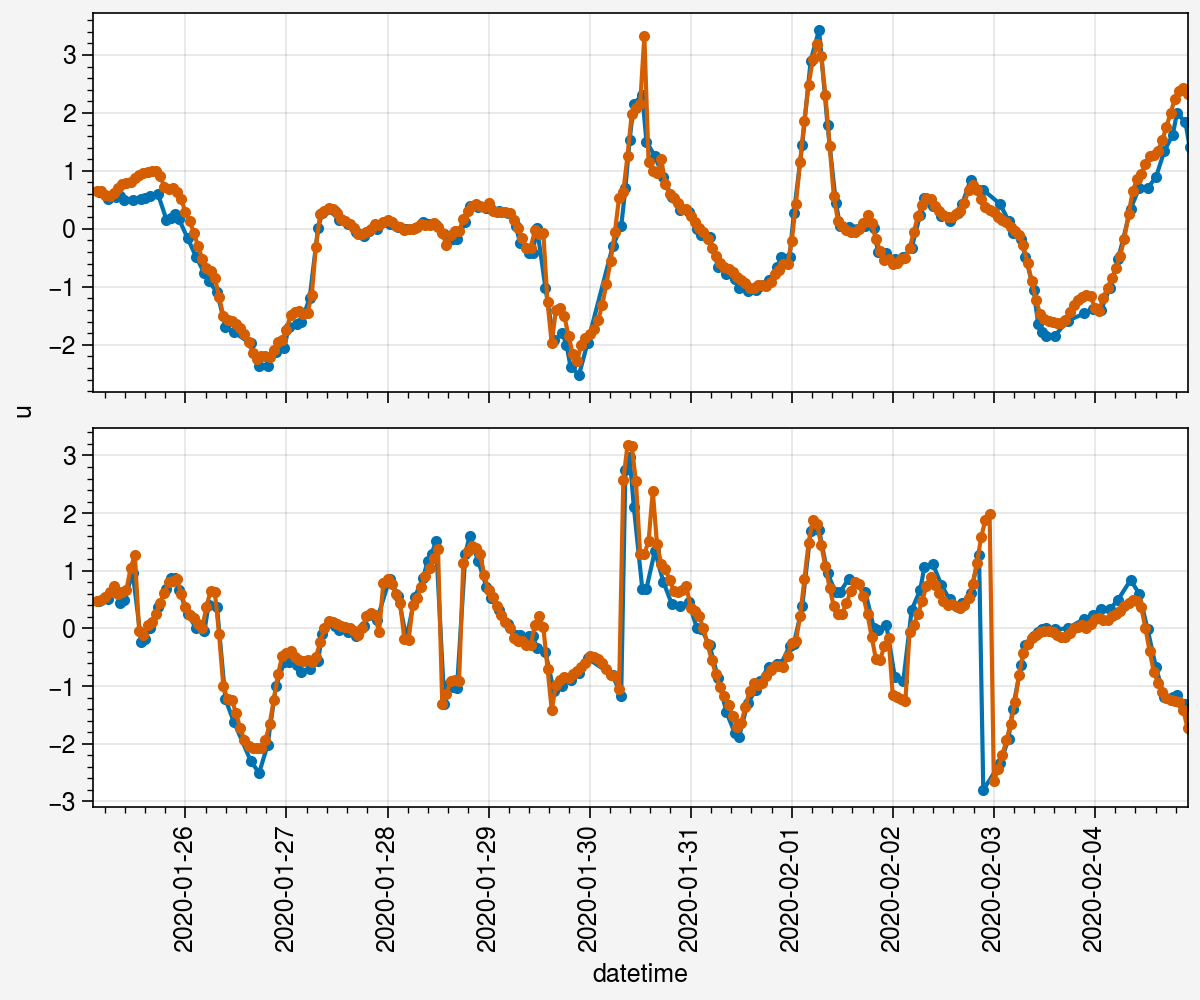

In [15]:
fig, ax = pplt.subplots(width=6, height=5, nrows=2)
ax[0].plot(zu_init, marker='.')
ax[0].plot(zu, marker='.')
ax[1].plot(zv_init, marker='.')
ax[1].plot(zv, marker='.')


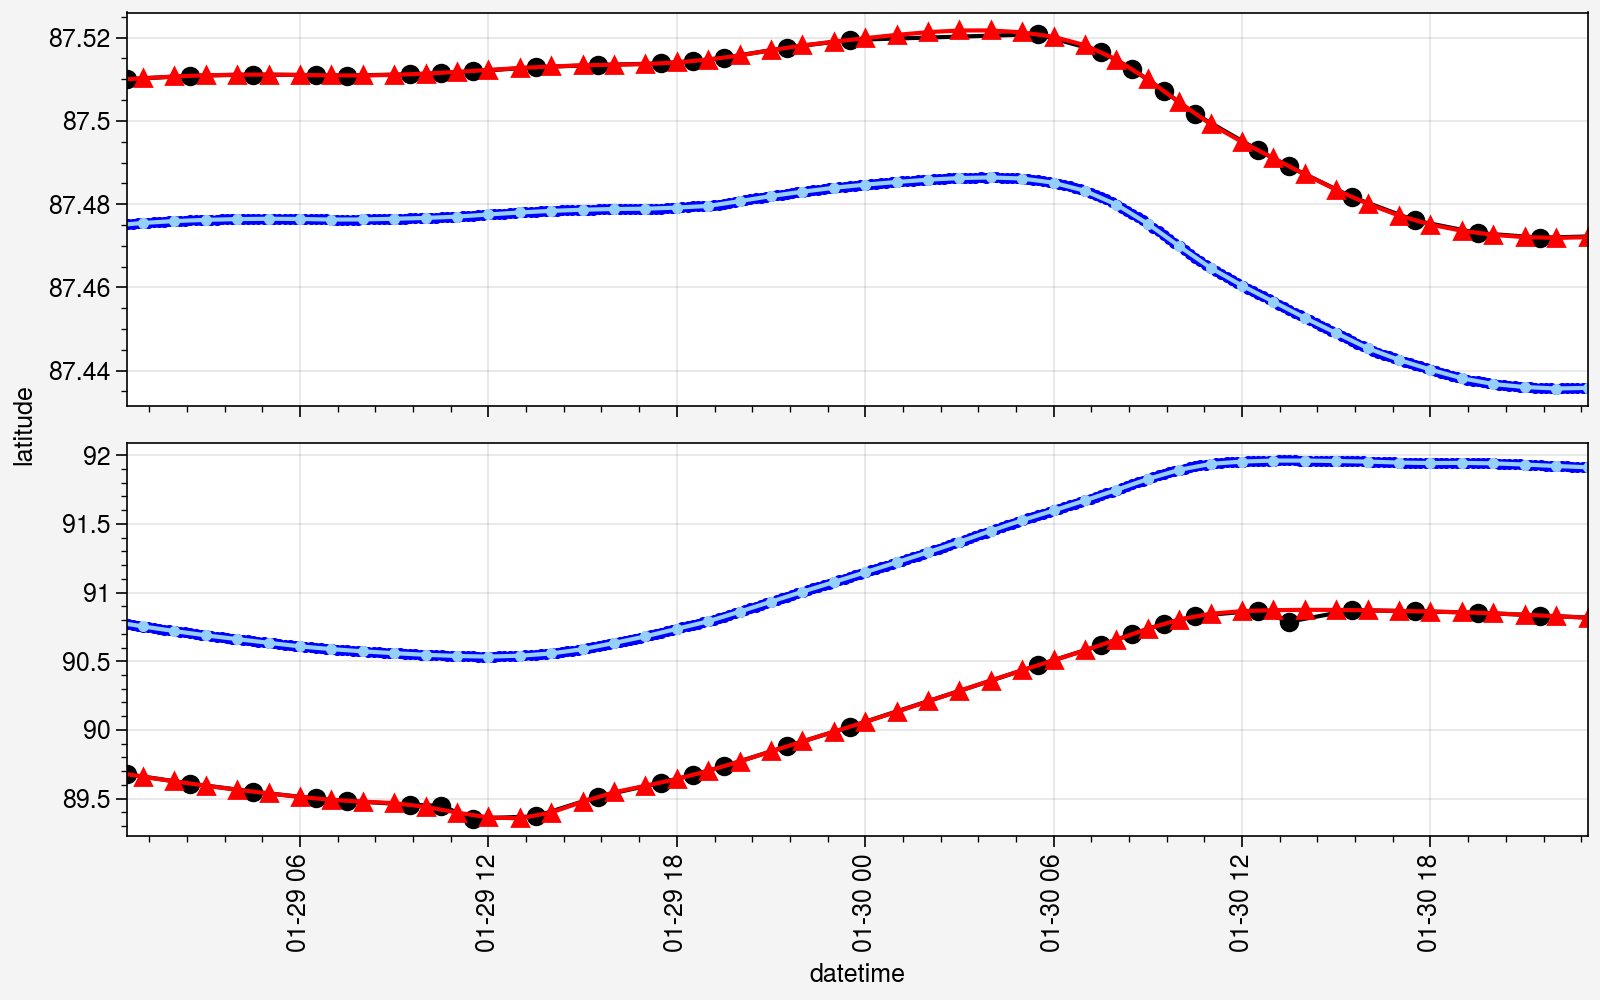

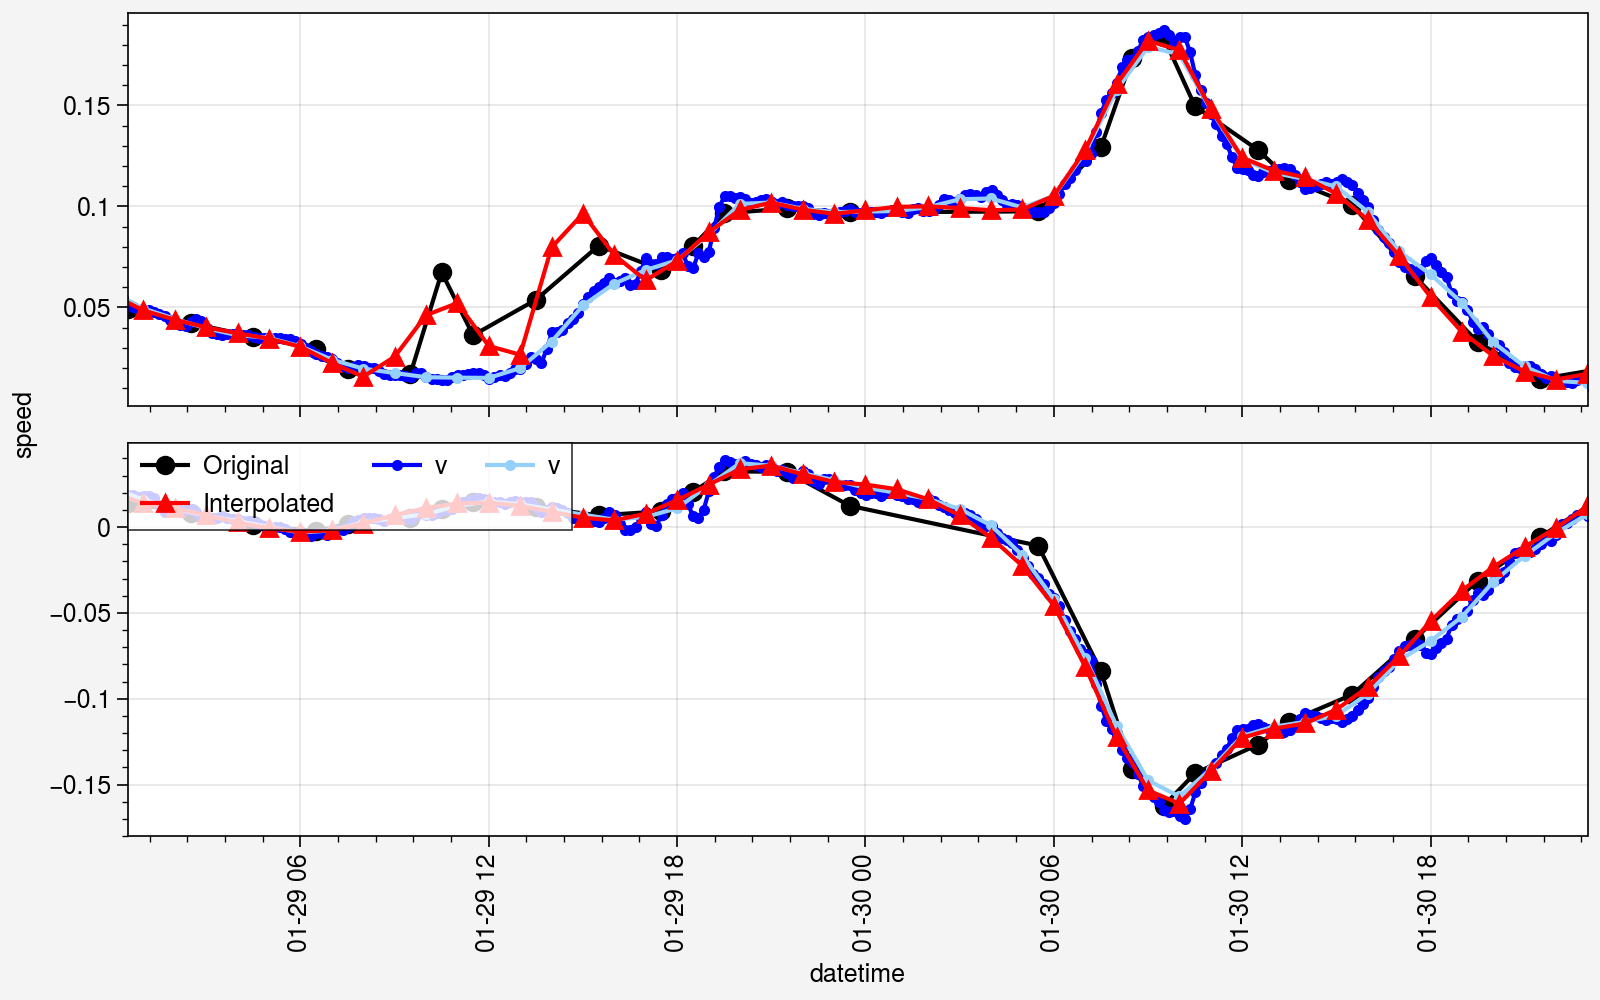

In [49]:
buoy = '2019P148'
ts = slice('2020-01-29', '2020-01-30')
df = buoy_orig[buoy]
df2 = buoy_data[buoy]
df_comp = buoy_orig['2019P105'] #6.5 km away
df_comp2 = buoy_data['2019P105'] #6.5 km away

fig, ax = pplt.subplots(width=8, height=5, nrows=2)
ax[0].plot(df.loc[ts, 'latitude'], marker='o', color='k')
ax[0].plot(df_comp.loc[ts, 'latitude'], marker='.', color='b')
ax[0].plot(df_comp2.loc[ts, 'latitude'], marker='.', color='light blue')
ax[0].plot(df2.loc[ts, 'latitude'], marker='^', color='r')
ax[1].plot(df.loc[ts, 'longitude'], marker='o', color='k')
ax[1].plot(df_comp.loc[ts, 'longitude'], marker='.', color='b')
ax[1].plot(df_comp2.loc[ts, 'longitude'], marker='.', color='light blue')
ax[1].plot(df2.loc[ts, 'longitude'], marker='^', color='r')
# ax[1].axvline(pd.to_datetime('2020-01-27 03:30:00'))

ts = slice('2020-01-29', '2020-01-30')
fig, ax = pplt.subplots(width=8, height=5, nrows=2)
ax[0].plot(df.loc[ts, 'speed'], marker='o', color='k')
ax[0].plot(df_comp.loc[ts, 'speed'], marker='.', color='b')
ax[0].plot(df_comp2.loc[ts, 'speed'], marker='.', color='light blue')
ax[0].plot(df2.loc[ts, 'speed'], marker='^', color='r')
ax[1].plot(df.loc[ts, 'v'], marker='o', color='k', label='Original')
ax[1].plot(df_comp.loc[ts, 'v'], marker='.', color='b')
ax[1].plot(df_comp2.loc[ts, 'v'], marker='.', color='light blue')
ax[1].plot(df2.loc[ts, 'v'], marker='^', color='r', label='Interpolated')
ax[1].legend(loc='ul')

In [51]:
buoy_data['2019P148'].loc[slice('2020-01-29 06:00', '2020-01-29 18:00')]

,x_stere,y_stere,data_gap_minutes,longitude,latitude,u,v,speed
datetime,,,,,,,,
2020-01-29 06:00:00,-2297.021432,-269652.194896,120.0,89.51194,87.51105,-0.030393,-0.002602,0.030505
2020-01-29 07:00:00,-2397.099080,-269664.329495,90.0,89.49070,87.51093,-0.022420,-0.001910,0.022501
2020-01-29 08:00:00,-2458.444869,-269665.944820,90.0,89.47767,87.51091,-0.015566,0.002098,0.015706
2020-01-29 09:00:00,-2509.171459,-269649.220432,90.0,89.46686,87.51106,-0.024571,0.007006,0.025551
2020-01-29 10:00:00,-2635.357845,-269615.502236,180.0,89.43998,87.51136,-0.044760,0.011131,0.046124
2020-01-29 11:00:00,-2831.446612,-269569.077495,180.0,89.39821,87.51177,-0.050268,0.013772,0.052121
2020-01-29 12:00:00,-2997.290808,-269516.344484,180.0,89.36284,87.51224,-0.027379,0.014297,0.030887
2020-01-29 13:00:00,-3028.576240,-269466.138488,180.0,89.35607,87.51270,0.023502,0.012391,0.026568
2020-01-29 14:00:00,-2828.074510,-269427.132095,180.0,89.39861,87.51308,0.079187,0.008978,0.079694


KeyError: '2020-01-29 12:30:00'

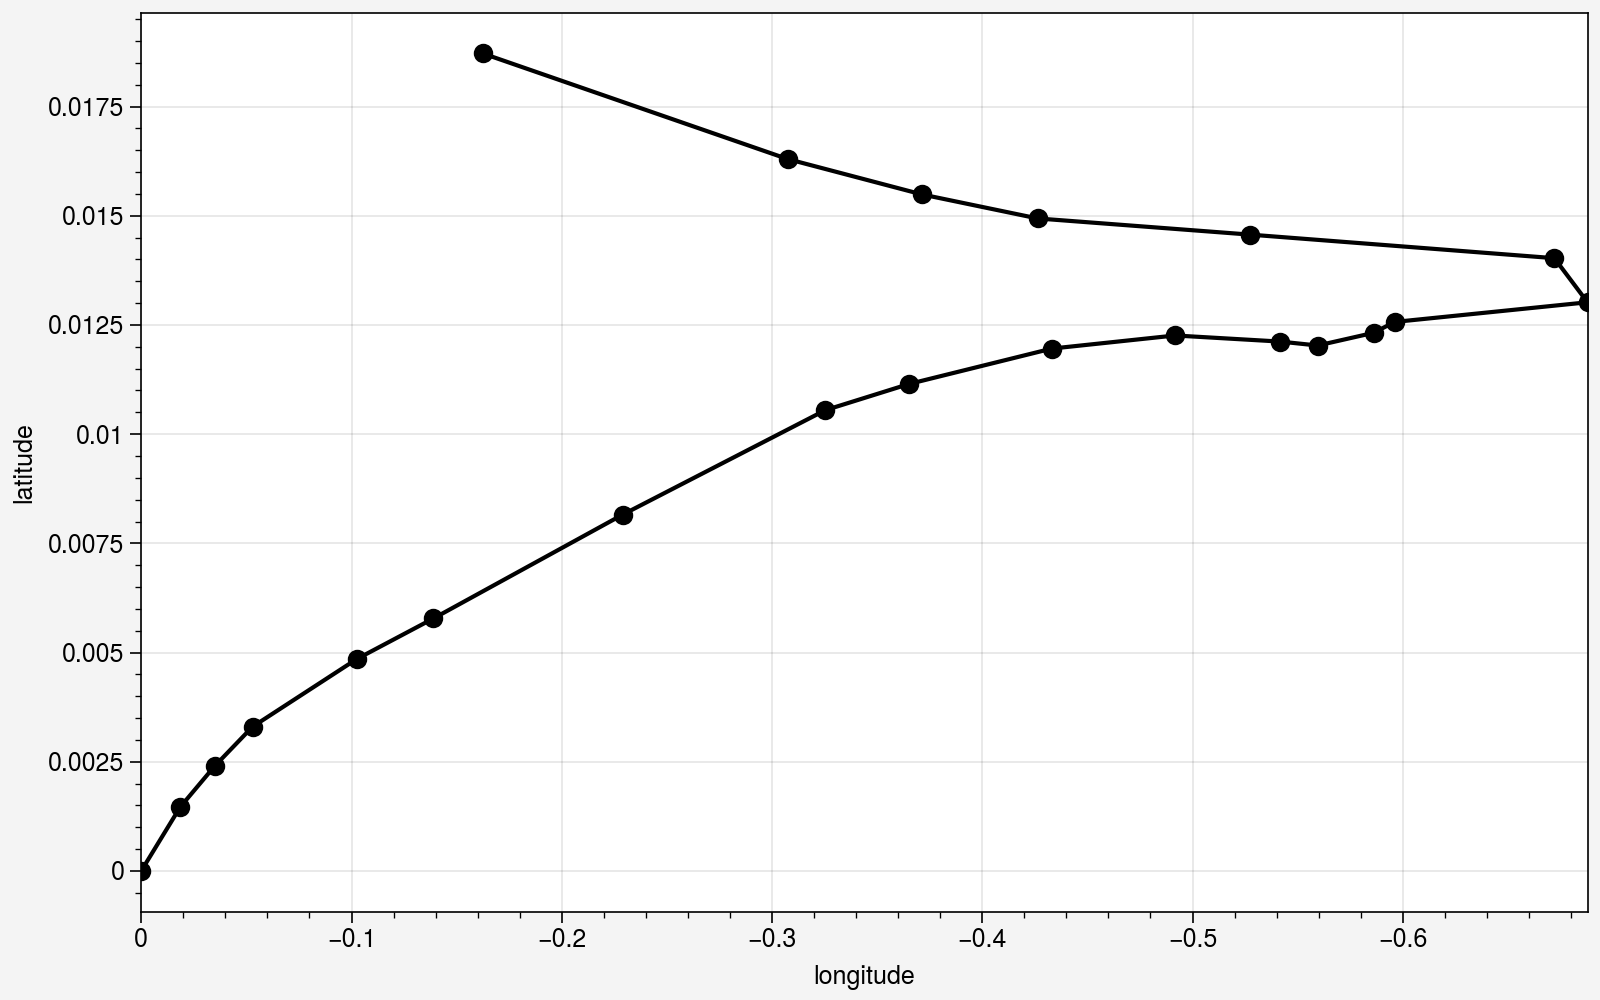

In [55]:
buoy = '2019P148'
ts = slice('2020-01-28 12:00', '2020-01-29 23:00')
df = buoy_orig[buoy]
df2 = buoy_data[buoy]
df_comp = buoy_orig['2019P105'] #6.5 km away
df_comp2 = buoy_data['2019P105'] #6.5 km away

fig, ax = pplt.subplots(width=8, height=5, nrows=1)
ax.plot(df.loc[ts, 'longitude'] - df.loc[ts, 'longitude'].values[0],
        df.loc[ts, 'latitude'] - df.loc[ts, 'latitude'].values[0],
        marker='o', color='k')
ax.plot(df.loc['2020-01-29 12:30:00', 'longitude'] - df.loc[ts, 'longitude'].values[0],
        df.loc['2020-01-29 12:30:00', 'latitude'] - df.loc[ts, 'latitude'].values[0], marker='x', ms=10)

ax.plot(df.loc['2020-01-29 11:30:00', 'longitude'] - df.loc[ts, 'longitude'].values[0],
        df.loc['2020-01-29 11:30:00', 'latitude'] - df.loc[ts, 'latitude'].values[0], marker='x', ms=10)
ax.plot(df_comp.loc[ts, 'longitude'] - df_comp.loc[ts, 'longitude'].values[0],
        df_comp.loc[ts, 'latitude'] - df_comp.loc[ts, 'latitude'].values[0],
        marker='.', color='b')
ax.plot(df_comp2.loc[ts, 'longitude'] - df_comp2.loc[ts, 'longitude'].values[0],
        df_comp2.loc[ts, 'latitude'] - df_comp2.loc[ts, 'latitude'].values[0],
        marker='.', color='light blue')
ax.plot(df2.loc[ts, 'longitude'] - df.loc[ts, 'longitude'].values[0],
        df2.loc[ts, 'latitude'] - df.loc[ts, 'latitude'].values[0], marker='^', color='r')
# ax[1].axvline(pd.to_datetime('2020-01-27 03:30:00'))

datetime
2020-01-29 11:30:00   -0.01576
Name: longitude, dtype: float64

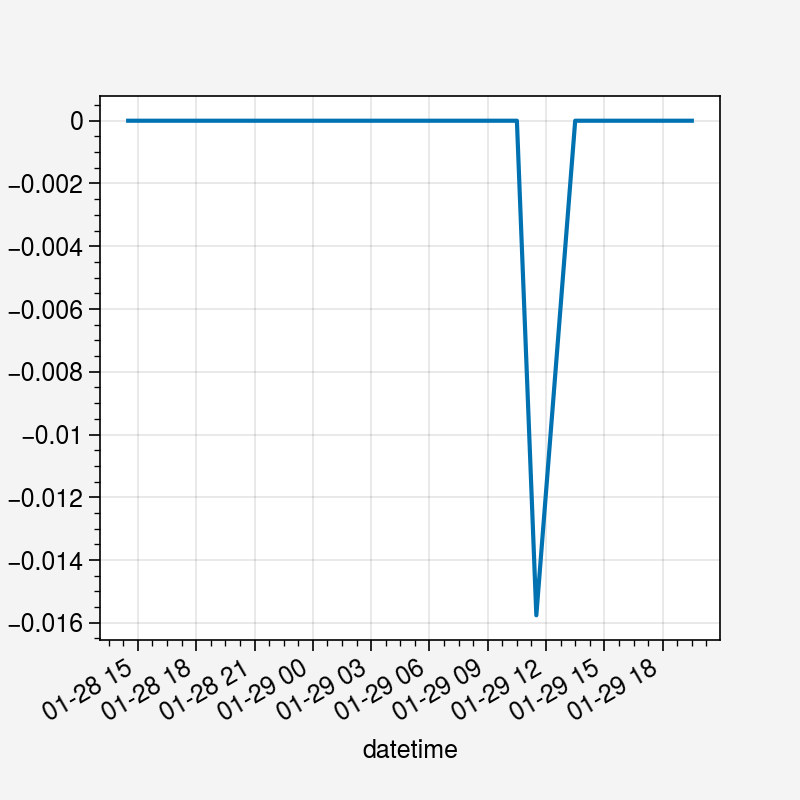

In [53]:
test = df.loc[ts, 'longitude'] - df.loc[ts, 'longitude'].rolling(3, center=True).median()
test.plot()
test[test < -0.01]

In [212]:
manual_flag = {'2019P137': ['2020-01-26 02:30:00', 
                           '2020-01-27 04:30:00'],
               '2019P138': ['2020-01-26 22:30:00'],
               '2019P139': ['2020-01-26 21:30:00'],
               '2019P148': ['2020-01-29 09:30:00', 
                            '2020-01-29 10:30:00', 
                            '2020-01-29 11:30:00']}

df.loc[slice('2020-01-29 11:00', '2020-01-29 13:00')]

,x_stere,y_stere,sigma_x_regrid,longitude,latitude,speed_check,x,y,u,v,speed
datetime,,,,,,,,,,,
2020-01-29 11:30:00,192750.5285,188456.16625,6.507814e-11,89.35458,87.51189,False,192750.5285,188456.16625,0.018068,0.003268,0.018361


In [188]:
buoy_orig['2019P148'].loc[slice('2020-01-29 11:00', '2020-01-29 13:00')]

,x_stere,y_stere,sigma_x_regrid,longitude,latitude,speed_check
datetime,,,,,,
2020-01-29 11:30:00,192750.5285,188456.16625,6.507814e-11,89.35458,87.51189,False


In [243]:
def distance(df1, df2):
    d = np.sqrt((df1.x_stere - df2.x_stere)**2 + (df1.y_stere - df2.y_stere)**2)
    return d

In [246]:
buoy_dist = pd.DataFrame({b: distance(buoy_data[b], buoy_data[buoy]) for b in buoy_data})

In [252]:
buoy_dist.mean(axis=0).sort_values().dropna()

2019P148         0.000000
2019P105      6589.838276
2019O6       10113.705724
2019T69      14167.779008
2019P197     15064.474861
                ...      
2019P22     150112.499360
2019P128    150496.494321
2019P123    152530.839572
2019P156    366904.774008
2019P157    471768.565823
Length: 67, dtype: float64

# Uncertainty in deformation

In [292]:
df_def = pd.read_csv('../data/strain_rates/DN_1.csv')
df_def['uncertainty_area']/df_def['area']

0           NaN
1      0.000495
2      0.000495
3      0.000495
4      0.000495
         ...   
260    0.000518
261    0.000518
262    0.000518
263    0.000518
264         NaN
Length: 265, dtype: float64